# PID Control with Anti=Reset-Windup

### 1. Additional Benefits of Tracking the Manipulated Variable 
### (Heater startup case)

In [2]:
# PID tracking controller 
def PID(Kp, Ki, Kd, MV_bar=0, beta=1, gamma=0):
    # initialize stored data
    eD_prev = 0
    t_prev = -100
    P = 0
    I = 0
    D = 0
    
    #initial control
    MV = MV_bar
    
    while True:
        # yield MV, wait for new t, SP, PV, TR
        t, PV, SP, TR = yield MV ### Tracking 
        
        # adjust I term so output matches tracking input
        I = TR - MV_bar - P - D ### Tracking 
        
        # PID calculations
        P = Kp*(beta*SP-PV)
        I = I + Ki*(SP-PV)*(t-t_prev)
        eD = gamma*SP-PV
        D = Kd*(eD-eD_prev)/(t-t_prev)
        MV = MV_bar + P + I + D
        
        # update stored data for next iteration
        eD_prev = eD
        t_prev = t

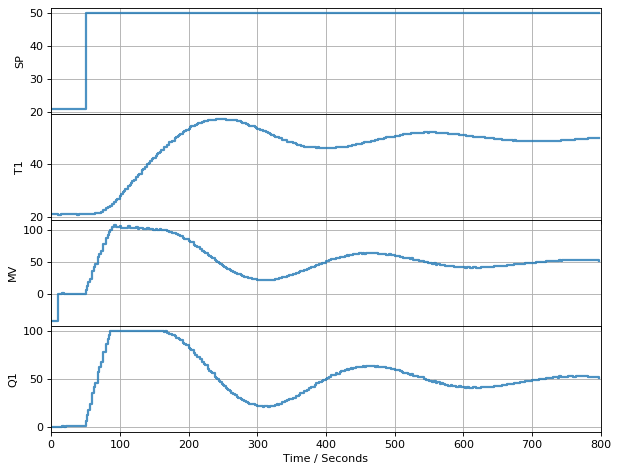

TCLab Model disconnected successfully.


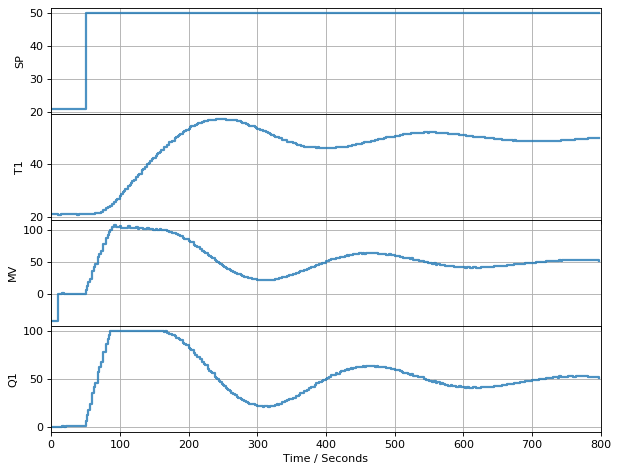

In [3]:
%matplotlib inline
from tclab import clock, setup, Historian, Plotter

TCLab = setup(connected=False, speedup=10)

controller = PID(2, 0.1, 2, beta=0) # create pid control
controller.send(None) # initialize

tfinal = 800

with TCLab() as lab:
    h = Historian([('SP',lambda:SP),('T1',lambda:lab.T1),('MV', lambda:MV),('Q1',lab.Q1)])
    p = Plotter(h, tfinal)
    T1 = lab.T1
    for t in clock(tfinal, 2):
        SP = T1 if t<50 else 50 # get setpoint
        PV = lab.T1 # get mesurement
        MV = controller.send([t, PV, SP, lab.Q1()]) # compute manipulated variable
        lab.Q1(MV) # apply
        p.update(t)

### 2.Embedding Anti-Reset Windup inside the Controller

#### The next cell modifies our control algorithm to accomodate this feature, and automatically detects if a tracking signal is passed to the controller.


In [4]:
def PID(Kp, Ki, Kd, MV_bar=0, beta=1, gamma=0):
    # initialize stored data
    eD_prev = 0
    t_prev = -100
    P = 0
    I = 0
    D = 0
    
    # initial control
    MV = MV_bar
    
    while True:
        # yield MV, wait for new t, SP, PV, TR
        data = yield MV # Create data for tracking
        
        # see if a tracking data is being supplied
        if len(data)<4: ######## 
            t, PV, SP = data
        else:
            t, PV, SP, TR = data
            I = TR - MV_bar - P - D
            
        # PID calculations
        P = Kp*(beta*SP-PV)
        I = I + Ki*(SP-PV)*(t-t_prev)
        eD = gamma*SP-PV
        D = Kd*(eD-eD_prev)/(t-t_prev)
        MV = MV_bar + P + I + D
        
        # Constrain MV to range 0 to 100 for anti-reset windup
        MV = 0 if MV < 0 else 100 if MV > 100 else MV ######## blending
        #I = MV - MV_bar - P - D
        
        # update stored data for next iteration
        eD_prev = eD
        t_prev = t

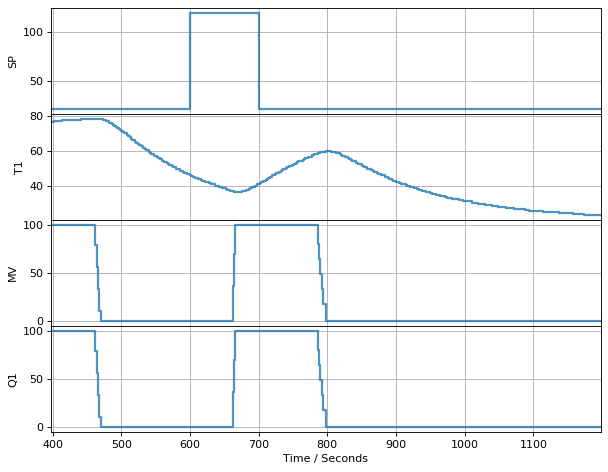

TCLab Model disconnected successfully.


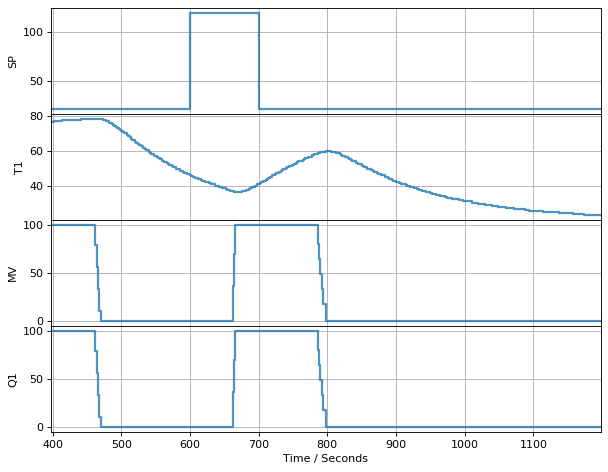

In [5]:
%matplotlib inline
from tclab import clock, setup, Historian, Plotter

TCLab = setup(connected = False, speedup=10)

controller = PID(1, 0.2, 0, beta=0) # create pid control
controller.send(None) # initialize

t_final = 1200

with TCLab() as lab:
    h = Historian([('SP', lambda: SP),('T1',lambda:lab.T1),('MV',lambda:MV),('Q1',lab.Q1)])
    p = Plotter(h, tfinal)
    Tlo = lab.T1
    Thi = 120
    for t in clock(t_final,2):
        SP = Thi if(t%600 < 100) else Tlo # get setpoint
        PV = lab.T1 # get measurement
        MV = controller.send([t,PV,SP]) # compute manipulated variable
        lab.Q1(MV) # apply
        p.update(t) # update information display

In [6]:
h.columns

['Time', 'SP', 'T1', 'MV', 'Q1']